In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/30-days-of-ml/sample_submission.csv
/kaggle/input/30-days-of-ml/train.csv
/kaggle/input/30-days-of-ml/test.csv
/kaggle/input/notebook92c67b5720/submission1.1.csv
/kaggle/input/notebook92c67b5720/submission0.3.csv
/kaggle/input/notebook92c67b5720/submission0.5.csv
/kaggle/input/notebook92c67b5720/submission1.7.csv
/kaggle/input/notebook92c67b5720/submission0.7.csv
/kaggle/input/notebook92c67b5720/__results__.html
/kaggle/input/notebook92c67b5720/submission0.7+ctb.csv
/kaggle/input/notebook92c67b5720/submission1.csv
/kaggle/input/notebook92c67b5720/__notebook_source__.ipynb
/kaggle/input/notebook92c67b5720/submission1.3.csv
/kaggle/input/notebook92c67b5720/__notebook__.ipynb
/kaggle/input/notebook92c67b5720/__output__.json
/kaggle/input/notebook92c67b5720/xgb_lgb_ctb_oof
/kaggle/input/notebook92c67b5720/submission0.3+ctb.csv
/kaggle/input/notebook92c67b5720/custom.css
/kaggle/input/notebook92c67b5720/__results___files/__results___8_1.png
/kaggle/input/notebook92c67b5720/cat

In [4]:
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
import random
import os

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge, Lasso
from sklearn.preprocessing import StandardScaler

In [5]:
train = pd.read_csv("/kaggle/input/30-days-of-ml/train.csv", index_col="id")
test  = pd.read_csv("/kaggle/input/30-days-of-ml/test.csv", index_col="id")

target = train["target"]
train = train.drop("target", axis=1)

In [6]:
train_add = pd.read_csv("/kaggle/input/notebook92c67b5720/xgb_lgb_ctb_oof")
train_add["id"] = train.index
train_add = train_add.set_index("id")
test_add  = pd.read_csv("/kaggle/input/notebook92c67b5720/submission1.csv").set_index("id")

In [7]:
train = pd.concat([train, train_add],axis=1)
test  = pd.concat([test , test_add ],axis=1).rename(columns={"target":"oof"})

In [8]:
train["oof"] = 0.5*train["xgb"] + 0.5*train["lgb"]
train = train.drop(["xgb", "lgb", "ctb"], axis=1)

In [9]:
Count_cols   = train.select_dtypes(exclude=['object']).columns
Cat_cols = [ col for col in train.columns if col not in Count_cols ]
print("Number of columns:", len(train.columns))
print("Number of catrgorical columns:", len(Cat_cols))
print("Number of continuous columns:",  len(Count_cols))

ordinalencoder = OrdinalEncoder()

OH_cat_train = pd.DataFrame(ordinalencoder.fit_transform(train[Cat_cols]))
OH_cat_test = pd.DataFrame(ordinalencoder.transform(test[Cat_cols]))

OH_cat_train.index = train.index
OH_cat_test.index = test.index

OH_num_train = train[Count_cols]
OH_num_test = test[Count_cols]

train   = pd.concat([OH_cat_train, OH_num_train], axis=1)
test   = pd.concat([OH_cat_test, OH_num_test], axis=1)

Number of columns: 25
Number of catrgorical columns: 10
Number of continuous columns: 15


In [57]:
import optuna 
import optuna.integration.lightgbm as lgbo

params = {'objective': 'poisson',  'metric': 'rmse' } #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=42)
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test)
model = lgbo.train(params,
                   lgb_train,
                   valid_sets=[lgb_valid],
                   verbose_eval=False,
                   num_boost_round=100,
                   early_stopping_rounds=5,) 
model.params

[I 2021-08-25 23:55:54,174] A new study created in memory with name: no-name-6fa58784-540b-4021-9e9a-182935a8171b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction, val_score: 0.718147:  14%|#4        | 1/7 [00:02<00:12,  2.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction, val_score: 0.717689:  29%|##8       | 2/7 [00:04<00:10,  2.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction, val_score: 0.717660:  43%|####2     | 3/7 [00:06<00:08,  2.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction, val_score: 0.717190:  57%|#####7    | 4/7 [00:08<00:06,  2.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction, val_score: 0.717190:  71%|#######1  | 5/7 [00:10<00:04,  2.16s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction, val_score: 0.716904:  86%|########5 | 6/7 [00:12<00:02,  2.06s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716904:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:   5%|5         | 1/20 [00:01<00:33,  1.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  10%|#         | 2/20 [00:03<00:35,  1.96s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  15%|#5        | 3/20 [00:06<00:39,  2.35s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  20%|##        | 4/20 [00:09<00:38,  2.39s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  25%|##5       | 5/20 [00:12<00:38,  2.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  30%|###       | 6/20 [00:14<00:36,  2.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  35%|###5      | 7/20 [00:16<00:30,  2.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  40%|####      | 8/20 [00:19<00:28,  2.39s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  45%|####5     | 9/20 [00:21<00:25,  2.34s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  50%|#####     | 10/20 [00:24<00:24,  2.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  55%|#####5    | 11/20 [00:25<00:19,  2.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  60%|######    | 12/20 [00:27<00:16,  2.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  65%|######5   | 13/20 [00:28<00:13,  1.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  70%|#######   | 14/20 [00:30<00:11,  1.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  75%|#######5  | 15/20 [00:32<00:09,  1.96s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  80%|########  | 16/20 [00:34<00:07,  1.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  85%|########5 | 17/20 [00:36<00:05,  1.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716734:  90%|######### | 18/20 [00:38<00:04,  2.04s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


num_leaves, val_score: 0.716615:  95%|#########5| 19/20 [00:40<00:01,  1.96s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716615:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716615:  10%|#         | 1/10 [00:02<00:23,  2.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716615:  20%|##        | 2/10 [00:04<00:16,  2.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716607:  30%|###       | 3/10 [00:06<00:14,  2.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716597:  40%|####      | 4/10 [00:08<00:11,  1.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716597:  50%|#####     | 5/10 [00:09<00:09,  1.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716597:  60%|######    | 6/10 [00:11<00:07,  1.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716596:  70%|#######   | 7/10 [00:13<00:05,  1.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716596:  80%|########  | 8/10 [00:15<00:03,  1.82s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


bagging, val_score: 0.716596:  90%|######### | 9/10 [00:16<00:01,  1.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction_stage2, val_score: 0.716596:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction_stage2, val_score: 0.716596:  33%|###3      | 1/3 [00:01<00:03,  2.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


feature_fraction_stage2, val_score: 0.716596:  67%|######6   | 2/3 [00:03<00:01,  1.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:   5%|5         | 1/20 [00:02<00:39,  2.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  10%|#         | 2/20 [00:04<00:37,  2.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  15%|#5        | 3/20 [00:06<00:34,  2.04s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  20%|##        | 4/20 [00:08<00:32,  2.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  25%|##5       | 5/20 [00:11<00:35,  2.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  30%|###       | 6/20 [00:13<00:32,  2.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  35%|###5      | 7/20 [00:15<00:29,  2.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  40%|####      | 8/20 [00:17<00:26,  2.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  45%|####5     | 9/20 [00:19<00:23,  2.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  50%|#####     | 10/20 [00:21<00:20,  2.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  55%|#####5    | 11/20 [00:23<00:18,  2.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  60%|######    | 12/20 [00:25<00:16,  2.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  65%|######5   | 13/20 [00:27<00:14,  2.04s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  70%|#######   | 14/20 [00:29<00:12,  2.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  75%|#######5  | 15/20 [00:31<00:10,  2.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  80%|########  | 16/20 [00:33<00:08,  2.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  85%|########5 | 17/20 [00:35<00:05,  2.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  90%|######### | 18/20 [00:37<00:04,  2.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


regularization_factors, val_score: 0.716596:  95%|#########5| 19/20 [00:39<00:02,  2.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


min_data_in_leaf, val_score: 0.716596:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.271048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


min_data_in_leaf, val_score: 0.716596:  20%|##        | 1/5 [00:02<00:10,  2.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


min_data_in_leaf, val_score: 0.716596:  40%|####      | 2/5 [00:04<00:06,  2.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


min_data_in_leaf, val_score: 0.716596:  60%|######    | 3/5 [00:06<00:04,  2.21s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


min_data_in_leaf, val_score: 0.716591:  80%|########  | 4/5 [00:08<00:02,  2.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188


min_data_in_leaf, val_score: 0.716591: 100%|##########| 5/5 [00:10<00:00,  2.15s/it]


{'objective': 'poisson',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 1.800928888186318e-08,
 'lambda_l2': 5.391958353979704e-07,
 'num_leaves': 5,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.8377921942020008,
 'bagging_freq': 5,
 'min_child_samples': 10,
 'num_iterations': 100,
 'early_stopping_round': 5}

In [62]:
model_params = {'objective': 'poisson',
             'metric': 'rmse',
             'feature_pre_filter': False,
             'lambda_l1': 1.800928888186318e-08,
             'lambda_l2': 5.391958353979704e-07,
             'num_leaves': 5,
             'feature_fraction': 1.0,
             'bagging_fraction': 0.8377921942020008,
             'bagging_freq': 5,
             'min_child_samples': 10,
             'num_iterations': 100,
             'early_stopping_round': 5,
              "learning_rate": 0.005,
            "num_iterations":80000,
            "early_stopping_round": 200}

In [63]:
final_preds = np.zeros(test.shape[0])
final_train_oof = np.zeros(train.shape[0])

kfd = KFold(n_splits=10, shuffle=True)

for fold, (train_idx, valid_idx) in enumerate(kfd.split(X=train, y=target)):
    print("-"*20, f"FOLD {fold}", "-"*20)
    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    
    train_dataset = lgb.Dataset(X_train, y_train)
    valid_dataset = lgb.Dataset(X_valid, y_valid)
    
    model = lgb.train(model_params, train_dataset, valid_sets=[valid_dataset], verbose_eval=1000)
    
    final_train_oof[valid_idx] = model.predict(X_valid)
    final_preds += model.predict(test) / 10

-------------------- FOLD 0 --------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 270000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109218
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.715998
Early stopping, best iteration is:
[1550]	valid_0's rmse: 0.715766
-------------------- FOLD 1 --------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 270000, nu

In [66]:
predictions = pd.DataFrame()
predictions["id"] = test.index
predictions["target"] = final_preds

predictions.to_csv('final_submission.csv', index=False, header=predictions.columns)

In [65]:
predictions = pd.DataFrame()
predictions["id"] = train.index
predictions["loss"] = final_train_oof

predictions.to_csv('final_train_oof.csv', index=False, header=predictions.columns)

In [67]:
Count_cols

Index(['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'oof'],
      dtype='object')

In [16]:
N_ESTIMATORS = 20000
lr = 0.01
SEED = 299792458
SPLITS = 10
VERBOSE = N_ESTIMATORS * 2
EARLY_STOPPING_ROUNDS = 100

In [78]:
xgb_params = {
    'random_state': 1, 
    'n_jobs': 4,
    'booster': 'gbtree',
    'n_estimators': 10000,
    'learning_rate': 0.034682894846408095,
    'reg_lambda': 1.224383455634919,
    'reg_alpha': 36.043214512614476,
    'subsample': 0.9219010649982458,
    'colsample_bytree': 0.11247495917687526,
    'max_depth': 3,
    'min_child_weight': 6,
    "tree_method":'gpu_hist',
    "gpu_id":0,
}

In [79]:
xgb_oof = np.zeros(train.shape[0])
#ctb_oof = np.zeros(train.shape[0])
lr_oof = np.zeros(train.shape[0])
elst_oof = np.zeros(train.shape[0])


xgb_pred = np.zeros(test.shape[0])
#ctb_pred = np.zeros(test.shape[0])
lr_pred = np.zeros(test.shape[0])
elst_pred = np.zeros(test.shape[0])


kfd = KFold(n_splits=SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(kfd.split(X=train, y=target)):
    print(f"-------------------------- FOLD {fold} --------------------------")
    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    
    xgb_model = xgb.XGBRegressor(**xgb_params)
#     xgb_model = xgb.XGBRegressor(
#             n_estimators=10000,
#             learning_rate=lr,
#             tree_method='gpu_hist',
#             gpu_id=0,
#             max_depth=2,
#             subsample=0.98,
#             colsample_bytree=0.10,
#             n_jobs=4,
#             booster= 'gbtree', 
#             reg_lambda= 66.1,
#             reg_alpha= 15.9,
#         )
    xgb_model.fit(X_train,
                  y_train,
                  eval_set=[(X_valid, y_valid)],
                  eval_metric="rmse",
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                  verbose=VERBOSE)
    
    valid_preds = xgb_model.predict(X_valid)
    xgb_oof[valid_idx]  = valid_preds
    xgb_pred +=  xgb_model.predict(test) / SPLITS
    
    print(f"FOLD: {fold} ---- Valid accuracy XGB: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------------
    
#     ctb_model = ctb.CatBoostRegressor(**ctb_params)
#     ctb_model.fit(X_train,
#                   y_train,
#                   eval_set=[(X_valid, y_valid)],
#                   use_best_model=True,
#                   early_stopping_rounds=EARLY_STOPPING_ROUNDS,
#                   verbose=VERBOSE)
    
#     valid_preds = ctb_model.predict(X_valid)
#     ctb_oof[valid_idx]  = valid_preds
#     ctb_pred += ctb_model.predict(test) / SPLITS
    
#     print(f"FOLD: {fold} ---- Valid accuracy CTB: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
     #------------------------------------------------------------------------------------------------------
    
    lr_model = LinearRegression()
    lr_model.fit(X_train,y_train)
    
    valid_preds = lr_model.predict(X_valid)
    lr_oof[valid_idx]  = valid_preds
    lr_pred += lr_model.predict(test) / SPLITS

    
    print(f"FOLD: {fold} ---- Valid accuracy Linear regression: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
     #------------------------------------------------------------------------------------------------------
      
    elst_model = ElasticNet(alpha=0.00001)
    elst_model.fit(X_train,y_train)
    
    valid_preds = elst_model.predict(X_valid)
    elst_oof[valid_idx]  = valid_preds
    elst_pred += elst_model.predict(test) / SPLITS

    
    print(f"FOLD: {fold} ---- Valid accuracy ElasticNet: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
     #------------------------------------------------------------------------------------------------------
    
    
print(f"oof xgb_rmse = {mean_squared_error(target, xgb_oof, squared=False)}")
print(f"oof ctb_rmse = {mean_squared_error(target, ctb_oof, squared=False)}")
print(f"oof lr_rmse = {mean_squared_error(target, lr_oof, squared=False)}")
print(f"oof elst_rmse = {mean_squared_error(target, elst_oof, squared=False)}")

-------------------------- FOLD 0 --------------------------
[0]	validation_0-rmse:7.51541
[1178]	validation_0-rmse:0.71757
FOLD: 0 ---- Valid accuracy XGB: 0.7175654748785141
FOLD: 0 ---- Valid accuracy Linear regression: 0.7169788640761806
FOLD: 0 ---- Valid accuracy ElasticNet: 0.7169797298238608
-------------------------- FOLD 1 --------------------------
[0]	validation_0-rmse:7.51123
[1180]	validation_0-rmse:0.71658
FOLD: 1 ---- Valid accuracy XGB: 0.7165790611883732
FOLD: 1 ---- Valid accuracy Linear regression: 0.7158004059863663
FOLD: 1 ---- Valid accuracy ElasticNet: 0.7158001175411398
-------------------------- FOLD 2 --------------------------
[0]	validation_0-rmse:7.51035
[1136]	validation_0-rmse:0.72069
FOLD: 2 ---- Valid accuracy XGB: 0.7206752557949039
FOLD: 2 ---- Valid accuracy Linear regression: 0.7201322444572431
FOLD: 2 ---- Valid accuracy ElasticNet: 0.7201307076179574
-------------------------- FOLD 3 --------------------------
[0]	validation_0-rmse:7.50438
[1270]

In [80]:
oof_dataset = pd.DataFrame()
oof_dataset["xgb"] = xgb_oof
#oof_dataset["ctb"] = ctb_oof
oof_dataset["lr"] = lr_oof
oof_dataset["elst"] = elst_oof
tmp = pd.read_csv("/kaggle/input/optuna-lgb/final_train_oof.csv", index_col="id")
tmp["id"] = oof_dataset.index
tmp = tmp.set_index("id")
oof_dataset["lgb"]  = tmp

pred_dataset = pd.DataFrame()
pred_dataset["xgb"] = xgb_pred
#pred_dataset["ctb"] = ctb_pred
pred_dataset["lr"] = lr_pred
pred_dataset["elst"] = elst_pred
tmp = pd.read_csv("/kaggle/input/optuna-lgb/final_submission.csv", index_col="id")
tmp["id"] = pred_dataset.index
tmp = tmp.set_index("id")
pred_dataset["lgb"] = tmp

In [81]:
pred_dataset.to_csv("pred_dataset.csv")
oof_dataset.to_csv("oof_dataset.csv")

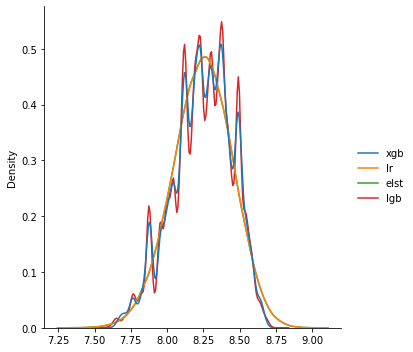

In [82]:
sns.displot(oof_dataset, kind="kde")

In [83]:
meta_model = Lasso(alpha =0.00001)
stacked_lasso_oof  = np.zeros(train.shape[0])
stacked_lasso_pred = np.zeros(test.shape[0])


kfd = KFold(n_splits=SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(kfd.split(X=oof_dataset, y=target)):
    print(f"-------------------------- FOLD {fold} --------------------------")
    X_train, X_valid = oof_dataset.iloc[train_idx], oof_dataset.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
                   
        
    meta_model = Lasso(alpha =0.00001)
    meta_model.fit(X_train, y_train)
    tmp_pred = meta_model.predict(X_valid)
    stacked_lasso_oof[valid_idx] = tmp_pred
    stacked_lasso_pred += meta_model.predict(pred_dataset) / SPLITS
    
    print("RMSE", mean_squared_error(tmp_pred, y_valid, squared=False))
    

-------------------------- FOLD 0 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1148.443248629279, tolerance: 15.048089508100238
  positive)


RMSE 0.7160580484378083
-------------------------- FOLD 1 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1138.4516788371693, tolerance: 15.05089345627248
  positive)


RMSE 0.7147845735839592
-------------------------- FOLD 2 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1155.4215627124504, tolerance: 15.038742550134659
  positive)


RMSE 0.7193304797296167
-------------------------- FOLD 3 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1003.8317792606395, tolerance: 15.04036587205772
  positive)


RMSE 0.7175227155001609
-------------------------- FOLD 4 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227.4033894228924, tolerance: 15.033935041943655
  positive)


RMSE 0.721514732108366
-------------------------- FOLD 5 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1002.8435381206364, tolerance: 15.045153786679553
  positive)


RMSE 0.7189528671982549
-------------------------- FOLD 6 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 936.0518169716815, tolerance: 15.044979331260931
  positive)


RMSE 0.7174823566802743
-------------------------- FOLD 7 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 919.4102712635213, tolerance: 15.07158395787907
  positive)


RMSE 0.712320318427783
-------------------------- FOLD 8 --------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1458.9793534293567, tolerance: 15.045543631372654
  positive)


RMSE 0.7187996736785706
-------------------------- FOLD 9 --------------------------
RMSE 0.7138816612624252


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1255.6241180006764, tolerance: 15.063056622585638
  positive)


In [84]:
predictions = pd.DataFrame()
predictions["id"] = test.index
predictions["target"] =stacked_lasso_pred

predictions.to_csv('stacked_lasso_pred.csv', index=False, header=predictions.columns)

In [88]:
pred_dataset["xgb"]

0         8.081543
1         8.409159
2         8.443038
3         8.529478
4         8.158248
            ...   
199995    7.975169
199996    8.494487
199997    8.490287
199998    8.130994
199999    7.956084
Name: xgb, Length: 200000, dtype: float64

In [93]:
predictions = pd.DataFrame()
predictions["id"] = test.index
predictions["target"] = pred_dataset["xgb"]

predictions.to_csv('xgboost_submission.csv', index=False, header=predictions.columns)

In [94]:
predictions = pd.DataFrame()
predictions["id"] = train.index
predictions["target"] = stacked_lasso_oof

predictions.to_csv('stacked_lasso_oof.csv', index=False, header=predictions.columns)